# Opioid Addiction Project
## Notebook 04: Modeling

This notebook executes the following tasks:

1. Model Preprocessing
2. Train a machine learning model
3. Score the model (measuring accuracy, precision, recall, F1, ROC)
4. Calibrate the model (and re-score, comparing uncalibrated vs. calibrated)
5. Save the model and calibration

Generating feature importance (Shapley values) was originally also part of this notebook, but the long  execution time of model training and calibration made it more efficient to include in a new notebook.

### W210, Capstone
Summer 2019

Team:  Cameron Kennedy, Aditi Khullar, Rachel Kramer, Sharad Varadarajan

# 0. Load Libraries and Set Global Variables
This analysis is performed in the cells below.

In [1]:
#Import Required Libraries

#General libraries
import numpy as np
import pandas as pd
from sklearn.externals import joblib  #Used to save (pickle) models
import itertools

#Model Preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE #conda install -c conda-forge imbalanced-learn
import OpioidDataPrep as odp  #Custom functions for this project

#Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost #Tricky installation, see instructions (search for XGBoost)

#Model evaluation
from sklearn.metrics import (accuracy_score, roc_curve, roc_auc_score, auc, confusion_matrix, 
                             classification_report, brier_score_loss, precision_score, 
                             recall_score, f1_score, log_loss, make_scorer)
from sklearn.model_selection import (learning_curve, validation_curve)


#Calibration
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

#Visualization
import matplotlib.pyplot as plt

#Set initial parameter(s)
pd.set_option('display.max_rows', 100)
pd.options.display.max_columns = 20
dataDir = './data/'

#Notebook Custom Parameters
useSMOTE = True

print('Pandas Version', pd.__version__)
print('XGBoost Version', xgboost.__version__)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Pandas Version 0.24.1
XGBoost Version 0.81


C:\Users\camke\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# 1. Load Data

This step loads the data from the file `features.pickle.zip`.

In [2]:
#Load Data
df = pd.read_pickle(dataDir+'features.pickle.zip')
df

,ADDPREV__GT1LTET2,ADDPREV__GT85LTET94,ADDPREV__GT94LTET97,ADDSCEV__GT1LTET2,ADDSCEV__GT2LTET94,ADDSCEV__GT94LTET97,ADDSCEV__GT97LTET98,ADDSCEV__GT98LTET99,AGE2,BOOKED__GT1LTET2,...,IRMJFY__GT50LTET100,IRMJFY__GT7LTET10,IRMJRC__GT1LTET2,IRMJRC__GT2LTET3,IRMJRC__GT3LTET9,IRSEX,MISUSE,TOBYR,TXEVRRCVD2,TXYRRECVD2
19,1,0,0,0,0,0,0,1,-1.188806,1,...,0,0,0,0,1,0,0,0,0,0
20,0,0,0,0,0,0,0,1,-0.730225,1,...,0,0,0,0,0,1,0,1,0,0
21,1,0,0,1,0,0,0,0,-0.607937,1,...,0,0,0,0,1,0,0,0,0,0
23,1,0,0,1,0,0,0,0,-0.944230,1,...,0,0,0,0,1,0,0,0,0,0
33,1,0,0,1,0,0,0,0,-0.730225,0,...,0,0,0,1,0,0,0,0,0,0
34,1,0,0,1,0,0,0,0,-0.883085,1,...,1,0,1,0,0,0,1,1,0,0
36,1,0,0,0,0,0,0,0,2.174124,1,...,0,0,0,0,1,1,0,0,0,0
46,1,0,0,1,0,0,0,0,-0.944230,1,...,0,0,0,0,0,1,1,0,0,0
50,1,0,0,1,0,0,0,0,0.462087,0,...,0,0,0,0,1,0,0,0,0,0
52,1,0,0,0,0,0,0,1,-1.188806,1,...,0,0,0,0,1,0,0,0,0,0


# 2. Model Preprocessing

In this section we'll ...

* Split the data into features (X) and the outcome variable, MISUSE (Y).
* Split the data into training, validation, and test sets.
* Oversample the data to address imbalance (optional, depending on modeling needs)

In [3]:
#We'll first sort the data by column name, necessary to prevent errors later
#Specfically, calibrating with the cv='prefit' option fails without this sort
df = odp.sortDFbyColName(df)
df

,ADDPREV__GT1LTET2,ADDPREV__GT85LTET94,ADDPREV__GT94LTET97,ADDSCEV__GT1LTET2,ADDSCEV__GT2LTET94,ADDSCEV__GT94LTET97,ADDSCEV__GT97LTET98,ADDSCEV__GT98LTET99,AGE2,BOOKED__GT1LTET2,...,IRMJFY__GT50LTET100,IRMJFY__GT7LTET10,IRMJRC__GT1LTET2,IRMJRC__GT2LTET3,IRMJRC__GT3LTET9,IRSEX,MISUSE,TOBYR,TXEVRRCVD2,TXYRRECVD2
19,1,0,0,0,0,0,0,1,-1.188806,1,...,0,0,0,0,1,0,0,0,0,0
20,0,0,0,0,0,0,0,1,-0.730225,1,...,0,0,0,0,0,1,0,1,0,0
21,1,0,0,1,0,0,0,0,-0.607937,1,...,0,0,0,0,1,0,0,0,0,0
23,1,0,0,1,0,0,0,0,-0.944230,1,...,0,0,0,0,1,0,0,0,0,0
33,1,0,0,1,0,0,0,0,-0.730225,0,...,0,0,0,1,0,0,0,0,0,0
34,1,0,0,1,0,0,0,0,-0.883085,1,...,1,0,1,0,0,0,1,1,0,0
36,1,0,0,0,0,0,0,0,2.174124,1,...,0,0,0,0,1,1,0,0,0,0
46,1,0,0,1,0,0,0,0,-0.944230,1,...,0,0,0,0,0,1,1,0,0,0
50,1,0,0,1,0,0,0,0,0.462087,0,...,0,0,0,0,1,0,0,0,0,0
52,1,0,0,0,0,0,0,1,-1.188806,1,...,0,0,0,0,1,0,0,0,0,0


## 2.1 Split Features (X) and Outcome (Y)

In [4]:
#Split X and Y
xCols = df.columns.difference(['MISUSE'])
dfX = df[xCols]
dfY = df.drop(xCols, axis=1)

#Inspect
print(dfX.head())
print(dfY.head(10))

    ADDPREV__GT1LTET2  ADDPREV__GT85LTET94  ADDPREV__GT94LTET97  \
19                  1                    0                    0   
20                  0                    0                    0   
21                  1                    0                    0   
23                  1                    0                    0   
33                  1                    0                    0   

    ADDSCEV__GT1LTET2  ADDSCEV__GT2LTET94  ADDSCEV__GT94LTET97  \
19                  0                   0                    0   
20                  0                   0                    0   
21                  1                   0                    0   
23                  1                   0                    0   
33                  1                   0                    0   

    ADDSCEV__GT97LTET98  ADDSCEV__GT98LTET99      AGE2  BOOKED__GT1LTET2  ...  \
19                    0                    1 -1.188806                 1  ...   
20                    0               

## 2.2 Split into Training, Validation, and Test

In [5]:
#Train, Val, Test splits
trainPct = 0.6
valPct = 0.25
testPct = 0.15

#Splitsville!
trainX, valtestX, trainY, valtestY = train_test_split(
    dfX, dfY, train_size=(trainPct), shuffle=True)
valX, testX, valY, testY = train_test_split(
     valtestX, valtestY, train_size=(valPct/(valPct+testPct)), shuffle=True)

#Check Shapes
print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)

(32014, 94)
(32014, 1)
(13340, 94)
(13340, 1)
(8004, 94)
(8004, 1)


In [6]:
#SMOTE Oversampling
if useSMOTE:
    #From https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
    os = SMOTE(random_state=0)
    columns = trainX.columns
    osX, osY = os.fit_sample(trainX, trainY)
    osX = pd.DataFrame(data=osX,columns=columns)
    osY = pd.DataFrame(data=osY,columns=['MISUSE'])

    #Check the numbers of our data
    print("length of oversampled data is ",len(osX))
    print("Number MISUSE==0",len(osY[osY['MISUSE']==0]))
    print("Number MISUSE==1",len(osY[osY['MISUSE']==1]))
    print("Proportion of MISUSE==0 in oversampled data is ",len(osY[osY['MISUSE']==0])/len(osX))
    print("Proportion of MISUSE==1 in oversampled data is ",len(osY[osY['MISUSE']==1])/len(osX))

    #Check Shapes
    print(trainX.shape)
    print(trainY.shape)
    print(osX.shape)
    print(osY.shape)
    print(valX.shape)
    print(valY.shape)
    print(testX.shape)
    print(testY.shape)

    #Finally, set trainX and trainY to be osX and osY 
    #(allows the model to use trainX and trainY regardless of whether oversampling is selected)
    trainX, trainY = osX, osY

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  53704
Number MISUSE==0 26852
Number MISUSE==1 26852
Proportion of MISUSE==0 in oversampled data is  0.5
Proportion of MISUSE==1 in oversampled data is  0.5
(32014, 94)
(32014, 1)
(53704, 94)
(53704, 1)
(13340, 94)
(13340, 1)
(8004, 94)
(8004, 1)


In [7]:
'''NO LONGER USING THIS, AND SAVING NUMPY FILES INSTEAD'''

#Save data files necessary for calculating feature importance, before conversion to numpy arrays
#valX.to_pickle(dataDir+'valX.pickle.zip')
#testX.to_pickle(dataDir+'testX.pickle.zip')
'''Note, the .to_pickle command INFERS zip compression based on the '.zip'
extension. Changing the extension will result in a HUGE file instead of a 
compressed file.
''';

## 2.3 Convert to Numpy

Next, we'll convert our data from pandas into numpy format, because several downstream components of the code / project don't work / work well with pandas, favoring the "numbers only" approach of numpy.  Specifically, this leads us to two tasks:

1. Convert data to numpy format.
2. Save column names for use later.

In [8]:
#Save column names to a pickle file
colNamesList = list(trainX.columns)

joblib.dump(colNamesList, dataDir+'colNamesList.zip')
    
'''To open in other files:
colNamesList = joblib.load(dataDir+'colNamesList.zip')
'''

#Convert dataframes to numpy arrays (do this AFTER saving column names)
trainX = trainX.values
trainY = trainY.values
valX = valX.values
valY = valY.values
testX = testX.values
testY = testY.values

#Save input data as numpy objects (for use in calculating feature importance, i.e., Shapley values)
np.save(arr=valX, file=dataDir+'valX.npy', allow_pickle=True)
np.save(arr=testX, file=dataDir+'testX.npy', allow_pickle=True)

# 3. Model Training

In this section we'll train a model.

Good article on validation loss: https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

## 3.1 Logistic Regression

Train a logistic regression model

In [9]:
#Set and train a logistic regression model
modelLR = LogisticRegression()
modelLR.fit(trainX, trainY)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\camke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

[learning_curve] Training set sizes: [ 4296 13962 23629 33295 42962]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    4.2s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.9s finished
No handles with labels found to put in legend.


RED = Training Data
GREEN = Cross Validation Data


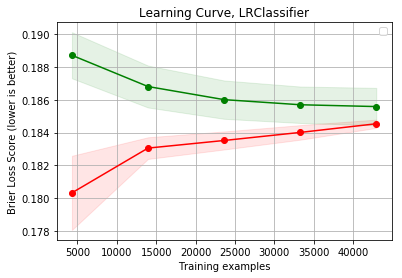

In [10]:
custScoreBrier = make_scorer(brier_score_loss, greater_is_better=True, needs_proba=True)

train_sizes, train_scores, test_scores = learning_curve(modelLR, trainX, trainY, n_jobs=-1, 
                                                        shuffle=True, verbose=2, cv=5, scoring=custScoreBrier)

#brier_score_loss

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve, LRClassifier")
plt.legend(loc="best")
plt.xlabel("Training examples")
plt.ylabel("Brier Loss Score (lower is better)")
#plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
#plt.ylim(-.1,1.1)
print('RED = Training Data')
print('GREEN = Cross Validation Data')
plt.show()

In [11]:
param_range=[5,10,15,20,25]

train_scores, test_scores = validation_curve(modelLR, trainX, trainY, 'max_iter', cv=5, n_jobs=-1, verbose=2,
                                              param_range=param_range, scoring=custScoreBrier)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    6.0s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.6s finished


No handles with labels found to put in legend.


[[0.18523315 0.18552302 0.18479059 0.18535373 0.18534747]
 [0.18441138 0.1848566  0.18412797 0.18466387 0.18464341]
 [0.18441138 0.1848566  0.18412797 0.18466387 0.18464341]
 [0.18441138 0.1848566  0.18412797 0.18466387 0.18464341]
 [0.18441138 0.1848566  0.18412797 0.18466387 0.18464341]]
[[0.1868433  0.18511169 0.18793014 0.18543236 0.18551095]
 [0.18669816 0.18419124 0.18716029 0.18486169 0.18503086]
 [0.18669816 0.18419124 0.18716029 0.18486169 0.18503086]
 [0.18669816 0.18419124 0.18716029 0.18486169 0.18503086]
 [0.18669816 0.18419124 0.18716029 0.18486169 0.18503086]]
RED = Training Data
GREEN = Cross Validation Data


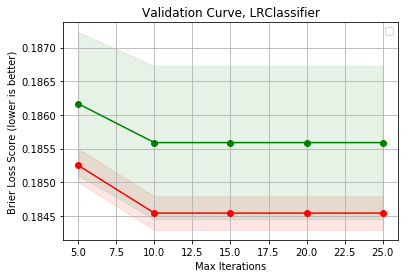

In [12]:
print(train_scores)
print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Validation Curve, LRClassifier")
plt.legend(loc="best")
plt.xlabel("Max Iterations")
plt.ylabel("Brier Loss Score (lower is better)")
#plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
#plt.ylim(-.1,1.1)
print('RED = Training Data')
print('GREEN = Cross Validation Data')
plt.show()

## 3.2 Extreme Gradient Boosting (XGBoost)

Train an XGBoost model.

In [13]:
#Custom Brier Scoring
def xg_Brier(y, t):
    t = t.get_label()
    return "Brier", brier_score_loss(t, y)

In [14]:
#Set and train the XGB model
modelXGB = xgboost.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=630, n_jobs=-1,
                                booster='gbtree'
                                )

# MD=5 NE=300:  .11___
# MD=3 NE=630:  .1117

#LONG TIME STABLE MODEL
# modelXGB = xgboost.XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=90, n_jobs=-1,
#                                 booster='gbtree'
#                                 )
'''Notes:
    1. n_jobs=-1 maximizes CPU utilization
    2. Beware running high max_depth and n_estimators; the shapley estimator in notebook 5
    crashes with high values ("The kernel appears to have died" with no error messages).'''
eval_set = [(trainX, trainY), (testX, testY)]
modelXGB.fit(trainX, trainY, eval_metric=xg_Brier, verbose=True, eval_set=eval_set) # eval_metric=['logloss'],

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\camke\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.275454	validation_1-error:0.21002	validation_0-Brier:0.237739	validation_1-Brier:0.239356
[1]	validation_0-error:0.275454	validation_1-error:0.21002	validation_0-Brier:0.227833	validation_1-Brier:0.230724
[2]	validation_0-error:0.26931	validation_1-error:0.21002	validation_0-Brier:0.219959	validation_1-Brier:0.223841
[3]	validation_0-error:0.260297	validation_1-error:0.215142	validation_0-Brier:0.212808	validation_1-Brier:0.217307
[4]	validation_0-error:0.25499	validation_1-error:0.215642	validation_0-Brier:0.206824	validation_1-Brier:0.212106
[5]	validation_0-error:0.250801	validation_1-error:0.218516	validation_0-Brier:0.201588	validation_1-Brier:0.207141
[6]	validation_0-error:0.249609	validation_1-error:0.224138	validation_0-Brier:0.196947	validation_1-Brier:0.202835
[7]	validation_0-error:0.245177	validation_1-error:0.216767	validation_0-Brier:0.193009	validation_1-Brier:0.199371
[8]	validation_0-error:0.237021	validation_1-error:0.219515	validation_0-Brie

[71]	validation_0-error:0.139952	validation_1-error:0.165667	validation_0-Brier:0.108952	validation_1-Brier:0.135872
[72]	validation_0-error:0.139431	validation_1-error:0.165417	validation_0-Brier:0.108643	validation_1-Brier:0.135656
[73]	validation_0-error:0.138854	validation_1-error:0.164668	validation_0-Brier:0.10832	validation_1-Brier:0.135449
[74]	validation_0-error:0.138053	validation_1-error:0.164918	validation_0-Brier:0.107712	validation_1-Brier:0.134989
[75]	validation_0-error:0.137271	validation_1-error:0.165042	validation_0-Brier:0.10744	validation_1-Brier:0.134755
[76]	validation_0-error:0.137401	validation_1-error:0.164918	validation_0-Brier:0.107018	validation_1-Brier:0.13451
[77]	validation_0-error:0.136638	validation_1-error:0.165167	validation_0-Brier:0.106891	validation_1-Brier:0.134496
[78]	validation_0-error:0.136079	validation_1-error:0.165292	validation_0-Brier:0.10646	validation_1-Brier:0.134259
[79]	validation_0-error:0.135856	validation_1-error:0.165292	validat

[141]	validation_0-error:0.118613	validation_1-error:0.155422	validation_0-Brier:0.091983	validation_1-Brier:0.124919
[142]	validation_0-error:0.118408	validation_1-error:0.155547	validation_0-Brier:0.091788	validation_1-Brier:0.124771
[143]	validation_0-error:0.118222	validation_1-error:0.155672	validation_0-Brier:0.091642	validation_1-Brier:0.124687
[144]	validation_0-error:0.118222	validation_1-error:0.155547	validation_0-Brier:0.09147	validation_1-Brier:0.124567
[145]	validation_0-error:0.11798	validation_1-error:0.155547	validation_0-Brier:0.091234	validation_1-Brier:0.124445
[146]	validation_0-error:0.117887	validation_1-error:0.155422	validation_0-Brier:0.091172	validation_1-Brier:0.124419
[147]	validation_0-error:0.117775	validation_1-error:0.155422	validation_0-Brier:0.091065	validation_1-Brier:0.124342
[148]	validation_0-error:0.117626	validation_1-error:0.155297	validation_0-Brier:0.091014	validation_1-Brier:0.124338
[149]	validation_0-error:0.117515	validation_1-error:0.155

[211]	validation_0-error:0.111388	validation_1-error:0.151049	validation_0-Brier:0.084534	validation_1-Brier:0.120679
[212]	validation_0-error:0.111016	validation_1-error:0.151299	validation_0-Brier:0.084357	validation_1-Brier:0.120559
[213]	validation_0-error:0.110941	validation_1-error:0.151174	validation_0-Brier:0.084149	validation_1-Brier:0.12049
[214]	validation_0-error:0.111016	validation_1-error:0.151049	validation_0-Brier:0.084099	validation_1-Brier:0.120437
[215]	validation_0-error:0.110941	validation_1-error:0.151049	validation_0-Brier:0.084046	validation_1-Brier:0.120399
[216]	validation_0-error:0.110792	validation_1-error:0.151049	validation_0-Brier:0.083937	validation_1-Brier:0.120306
[217]	validation_0-error:0.110178	validation_1-error:0.150925	validation_0-Brier:0.083765	validation_1-Brier:0.120229
[218]	validation_0-error:0.110029	validation_1-error:0.1508	validation_0-Brier:0.083723	validation_1-Brier:0.120188
[219]	validation_0-error:0.109992	validation_1-error:0.1508

[282]	validation_0-error:0.104387	validation_1-error:0.14955	validation_0-Brier:0.07981	validation_1-Brier:0.118551
[283]	validation_0-error:0.104089	validation_1-error:0.148676	validation_0-Brier:0.079775	validation_1-Brier:0.118539
[284]	validation_0-error:0.10407	validation_1-error:0.148551	validation_0-Brier:0.079736	validation_1-Brier:0.118541
[285]	validation_0-error:0.104089	validation_1-error:0.148801	validation_0-Brier:0.079709	validation_1-Brier:0.118533
[286]	validation_0-error:0.103996	validation_1-error:0.148801	validation_0-Brier:0.079672	validation_1-Brier:0.118515
[287]	validation_0-error:0.103996	validation_1-error:0.148801	validation_0-Brier:0.079645	validation_1-Brier:0.118494
[288]	validation_0-error:0.103679	validation_1-error:0.148801	validation_0-Brier:0.079544	validation_1-Brier:0.118461
[289]	validation_0-error:0.103754	validation_1-error:0.14905	validation_0-Brier:0.079473	validation_1-Brier:0.118443
[290]	validation_0-error:0.103661	validation_1-error:0.14880

[352]	validation_0-error:0.100998	validation_1-error:0.148176	validation_0-Brier:0.077275	validation_1-Brier:0.117562
[353]	validation_0-error:0.100905	validation_1-error:0.148301	validation_0-Brier:0.077255	validation_1-Brier:0.117556
[354]	validation_0-error:0.100924	validation_1-error:0.148301	validation_0-Brier:0.077214	validation_1-Brier:0.117549
[355]	validation_0-error:0.100961	validation_1-error:0.148426	validation_0-Brier:0.077202	validation_1-Brier:0.117542
[356]	validation_0-error:0.100942	validation_1-error:0.148051	validation_0-Brier:0.077174	validation_1-Brier:0.117537
[357]	validation_0-error:0.100942	validation_1-error:0.148051	validation_0-Brier:0.077119	validation_1-Brier:0.117503
[358]	validation_0-error:0.100942	validation_1-error:0.148051	validation_0-Brier:0.077092	validation_1-Brier:0.117484
[359]	validation_0-error:0.100961	validation_1-error:0.148176	validation_0-Brier:0.07703	validation_1-Brier:0.117441
[360]	validation_0-error:0.100477	validation_1-error:0.14

[422]	validation_0-error:0.098559	validation_1-error:0.147426	validation_0-Brier:0.0752	validation_1-Brier:0.116797
[423]	validation_0-error:0.098522	validation_1-error:0.147301	validation_0-Brier:0.075174	validation_1-Brier:0.116761
[424]	validation_0-error:0.098428	validation_1-error:0.147176	validation_0-Brier:0.075133	validation_1-Brier:0.116761
[425]	validation_0-error:0.09841	validation_1-error:0.147426	validation_0-Brier:0.075124	validation_1-Brier:0.116766
[426]	validation_0-error:0.098354	validation_1-error:0.147426	validation_0-Brier:0.075091	validation_1-Brier:0.116748
[427]	validation_0-error:0.098354	validation_1-error:0.147301	validation_0-Brier:0.075073	validation_1-Brier:0.116741
[428]	validation_0-error:0.098335	validation_1-error:0.147301	validation_0-Brier:0.07504	validation_1-Brier:0.116721
[429]	validation_0-error:0.098354	validation_1-error:0.147301	validation_0-Brier:0.075034	validation_1-Brier:0.11672
[430]	validation_0-error:0.098298	validation_1-error:0.147301

[492]	validation_0-error:0.09746	validation_1-error:0.147051	validation_0-Brier:0.073978	validation_1-Brier:0.116449
[493]	validation_0-error:0.09746	validation_1-error:0.147051	validation_0-Brier:0.073955	validation_1-Brier:0.116437
[494]	validation_0-error:0.09746	validation_1-error:0.147176	validation_0-Brier:0.073941	validation_1-Brier:0.116423
[495]	validation_0-error:0.09746	validation_1-error:0.147176	validation_0-Brier:0.073935	validation_1-Brier:0.116417
[496]	validation_0-error:0.097348	validation_1-error:0.147301	validation_0-Brier:0.073923	validation_1-Brier:0.116417
[497]	validation_0-error:0.097404	validation_1-error:0.147426	validation_0-Brier:0.073887	validation_1-Brier:0.116391
[498]	validation_0-error:0.097423	validation_1-error:0.147301	validation_0-Brier:0.073873	validation_1-Brier:0.116375
[499]	validation_0-error:0.097404	validation_1-error:0.147176	validation_0-Brier:0.073849	validation_1-Brier:0.116352
[500]	validation_0-error:0.097367	validation_1-error:0.14717

[562]	validation_0-error:0.097013	validation_1-error:0.148051	validation_0-Brier:0.072966	validation_1-Brier:0.116184
[563]	validation_0-error:0.097032	validation_1-error:0.147926	validation_0-Brier:0.072951	validation_1-Brier:0.116179
[564]	validation_0-error:0.097032	validation_1-error:0.147801	validation_0-Brier:0.072944	validation_1-Brier:0.116172
[565]	validation_0-error:0.097088	validation_1-error:0.148176	validation_0-Brier:0.072926	validation_1-Brier:0.116182
[566]	validation_0-error:0.097106	validation_1-error:0.148051	validation_0-Brier:0.072915	validation_1-Brier:0.116181
[567]	validation_0-error:0.097106	validation_1-error:0.148051	validation_0-Brier:0.072904	validation_1-Brier:0.116177
[568]	validation_0-error:0.097106	validation_1-error:0.148301	validation_0-Brier:0.072895	validation_1-Brier:0.116184
[569]	validation_0-error:0.097106	validation_1-error:0.148301	validation_0-Brier:0.072854	validation_1-Brier:0.116174
[570]	validation_0-error:0.097069	validation_1-error:0.1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=630,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

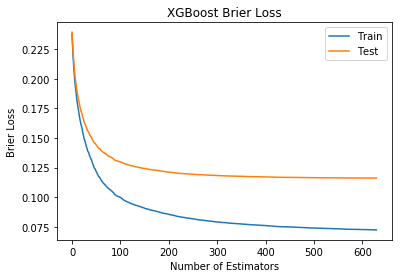

In [15]:
#Plot Log Loss Train vs. Test sets

results = modelXGB.evals_result()

epochs = len(results['validation_0']['Brier'])

x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['Brier'], label='Train')
ax.plot(x_axis, results['validation_1']['Brier'], label='Test')
ax.legend()
plt.xlabel('Number of Estimators')
plt.ylabel('Brier Loss')
plt.title('XGBoost Brier Loss')
plt.show()

In [16]:
#Build validation curve.  This cell takes ~1 min to run
runThis = False
if runThis:
    param_range=[25,50,75,100]
    
    train_scores, test_scores = validation_curve(modelXGB, trainX, trainY,
                                                 'n_estimators', cv=4, n_jobs=-1,
                                                 verbose=2, param_range=param_range,
                                                 scoring=custScoreBrier
                                                )

No handles with labels found to put in legend.


[[0.18523315 0.18552302 0.18479059 0.18535373 0.18534747]
 [0.18441138 0.1848566  0.18412797 0.18466387 0.18464341]
 [0.18441138 0.1848566  0.18412797 0.18466387 0.18464341]
 [0.18441138 0.1848566  0.18412797 0.18466387 0.18464341]
 [0.18441138 0.1848566  0.18412797 0.18466387 0.18464341]]
[[0.1868433  0.18511169 0.18793014 0.18543236 0.18551095]
 [0.18669816 0.18419124 0.18716029 0.18486169 0.18503086]
 [0.18669816 0.18419124 0.18716029 0.18486169 0.18503086]
 [0.18669816 0.18419124 0.18716029 0.18486169 0.18503086]
 [0.18669816 0.18419124 0.18716029 0.18486169 0.18503086]]
RED = Training Data
GREEN = Cross Validation Data


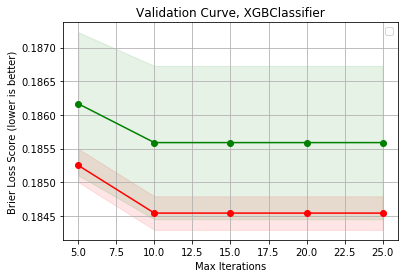

In [17]:
print(train_scores)
print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Validation Curve, XGBClassifier")
plt.legend(loc="best")
plt.xlabel("Max Iterations")
plt.ylabel("Brier Loss Score (lower is better)")
#plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
#plt.ylim(-.1,1.1)
print('RED = Training Data')
print('GREEN = Cross Validation Data')
plt.show()

## 3.3 Neural Network

In [18]:
#Set and train NN classifier
modelNN = MLPClassifier(hidden_layer_sizes=(5, 5, 5), max_iter=200)
modelNN.fit(trainX, trainY)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\camke\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 5, 5), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

# 4. Model Evaluation (uncalibrated)

Here we'll develop the scoring routines to evaluate the uncalibrated model. We'll re-score in the calibration section to compare the uncalibrated vs. calibrated models.

## 4.1 Simple Counts

We'll begin by calculating simple counts of the model's predictions

In [19]:
#Count predictions. This gives a rough idea of the number of predictions
def predCounts(predsIn):
    '''Simple function to count our predictions
    NOTES:
    Return format: [[prediction1, count of prediction1]
                    [prediction2, count of prediction2]]

    The .T at the end simply transposes the array.

    What's nice about this function is it will also detect any counts
    that aren't 0 or 1, which can occasionally happen.
    '''
    return np.asarray(np.unique(predsIn, return_counts=True)).T

preds = modelXGB.predict(valX)
predCountFreq = predCounts(preds)
#print(predCountFreq) #Commenting out here because it's printed below

## 4.2 Confusion Matrix

In [20]:
#Helper Functions for Summarizing and Plotting Results
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    Documented here as it is in the source.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized Confusion Matrix") #Commenting out since we plot this in a graph
    else:
        pass
        #print('Confusion Matrix') #Commenting out since we plot this in a graph

    #print(cm) #Commenting out since we plot this in a graph

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=20)
    plt.yticks(tick_marks, classes, size=20)

    fmt = '.1%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=20)
    plt.xlabel('Predicted label', size=20)

In [21]:
#Create text classification report
#print(classification_report(valY, preds)) #Commenting out here because it's printed below

# Compute confusion matrix
cnf_matrix = confusion_matrix(valY, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0, 1]

## 4.3 ROC Curve

In [22]:
#Function to plot ROC Curve
def pltROCCurve(fprIn, tprIn, trueY, predProbs):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fprIn, tprIn, 'b', label = 'AUC = %0.2f' % roc_auc_score(y_true=trueY, y_score=predProbs))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate\n(how often predicts misuse when no misuse)')
    plt.ylabel('True Positive Rate\n(how often predicts misuse when actual misuse)')
    plt.show()

## 4.4 Calibraiton Curve

In [23]:
#Function to plot calibration curve
def pltCalCurve(y_true, y_prob):
    prob_true, prob_pred = calibration_curve(y_true=y_true, y_prob=y_prob, 
                                             n_bins=20, strategy='quantile', normalize=False)

    #Plot diag line
    plt.plot([0, 1], [0, 1], linestyle='--')

    #Plot calibration curves
    plt.plot(prob_pred, prob_true, marker='.')
    plt.xlabel('Predicted Probabilities')
    plt.ylabel('Actual Probabilities')
    plt.show()

## 4.5 Metrics Summary

This is just a convenient place to put all the metrics we've already calculated in one spot.

In [24]:
def resultsSummary(preds, predProbs, trueY):
    #Calculate Inputs
    cnf_matrix = confusion_matrix(trueY, preds)

    #Counts
    print('PREDICTION COUNTS:\n', predCounts(preds))

    #Accuracy
    print('\nACCURACY SCORES:')
    print('Model Accuracy: {:.2%}'.format(accuracy_score(y_true=trueY, y_pred=preds, normalize=True)))
    print('Model ROC AUC:  {:.2%}'.format(roc_auc_score(y_true=trueY, y_score=predProbs)))
    print('Brier Score Loss:  {:.3}'.format(brier_score_loss(y_true=trueY, y_prob=predProbs)))
    print('  (Brier Score Loss evaluates probability estimates, lower is better)')

    #Descriptive Stats
    print('\nDESCRIPTIVE STATS ON PREDICTED PROBABILITIES:')
    print(pd.DataFrame({'Descriptive Stats':predProbs}).describe())
    
    #Distribution of Predictions
    print('\nDISTRIBUTION OF PREDICTED PROBABILITIES:')
    plt.hist(predProbs, bins=50)
    plt.show()

    #Classificaiton Report
    print('\nCLASSIFICATION REPORT:')
    print(classification_report(trueY, preds))

    #Plot Confusion Matrix
    print('CONFUSION MATRIX:')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
    plt.show()

    #Print ROC Curve
    fpr, tpr, thresholds = roc_curve(trueY, predProbs)
    print('ROC CURVE:')
    pltROCCurve(fpr, tpr, trueY, predProbs)
    
    #Plot CalCurve
    pltCalCurve(trueY, predProbs)

## 4.6 Run Evaluations

### 4.6.1 Evaluate Logistic Regression Model

PREDICTION COUNTS:
 [[   0 9395]
 [   1 3945]]

ACCURACY SCORES:
Model Accuracy: 75.52%
Model ROC AUC:  77.63%
Brier Score Loss:  0.182
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count       13340.000000
mean            0.412026
std             0.226838
min             0.013777
25%             0.242148
50%             0.366883
75%             0.546401
max             0.998159

DISTRIBUTION OF PREDICTED PROBABILITIES:


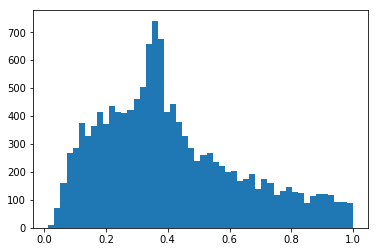


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     11130
           1       0.37      0.65      0.47      2210

    accuracy                           0.76     13340
   macro avg       0.64      0.71      0.66     13340
weighted avg       0.83      0.76      0.78     13340

CONFUSION MATRIX:


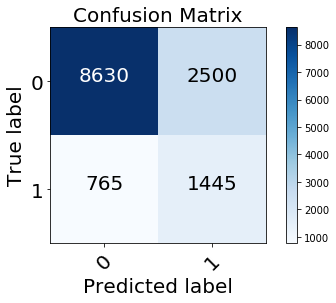

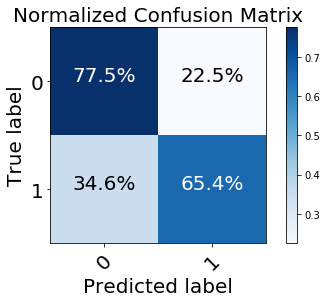

ROC CURVE:


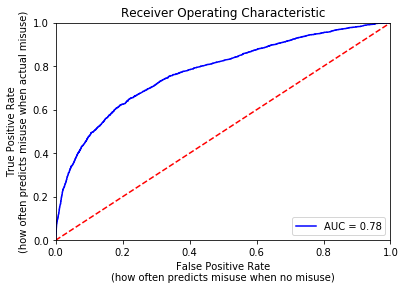

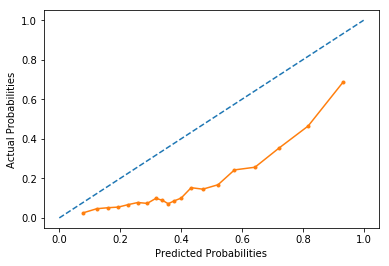

In [25]:
#Generate LR Predictions
predsLR = modelLR.predict(valX)
predProbsLR = modelLR.predict_proba(valX)[:, 1]

np.save(file=dataDir+'modelLRPredProbs.npy', arr=predProbsLR)

#Summarize
resultsSummary(predsLR, predProbsLR, valY)

### 4.6.2 Evaluate XGB Model

PREDICTION COUNTS:
 [[    0 12405]
 [    1   935]]

ACCURACY SCORES:
Model Accuracy: 85.46%
Model ROC AUC:  75.64%
Brier Score Loss:  0.115
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count       13340.000000
mean            0.190957
std             0.173402
min             0.003039
25%             0.071788
50%             0.134485
75%             0.254948
max             0.983437

DISTRIBUTION OF PREDICTED PROBABILITIES:


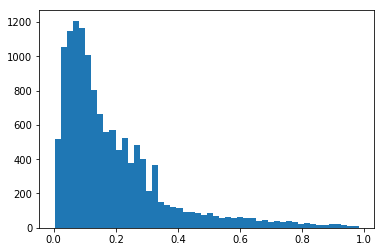


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     11130
           1       0.64      0.27      0.38      2210

    accuracy                           0.85     13340
   macro avg       0.76      0.62      0.65     13340
weighted avg       0.83      0.85      0.83     13340

CONFUSION MATRIX:


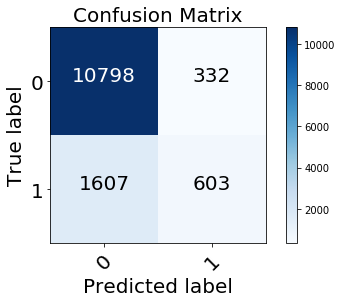

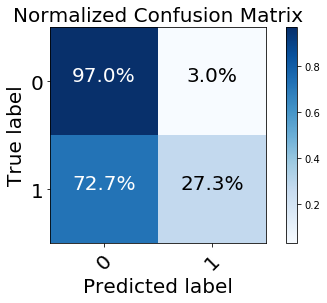

ROC CURVE:


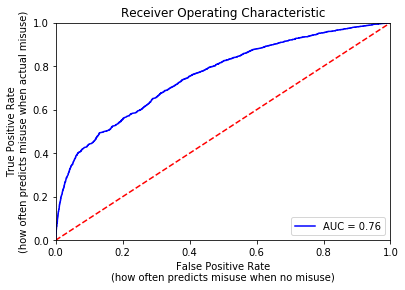

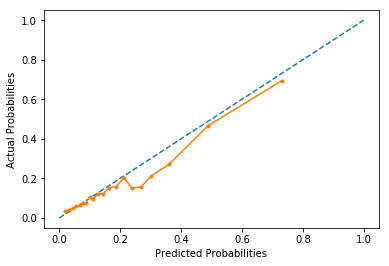

In [26]:
#Generate XGB Predictions
predsXGB = modelXGB.predict(valX)
predProbsXGB = modelXGB.predict_proba(valX)[:, 1]

np.save(file=dataDir+'modelXGBPredProbs.npy', arr=predProbsXGB)

#Summarize
resultsSummary(predsXGB, predProbsXGB, valY)

### 4.6.3 Evaluate Neural Network Model

PREDICTION COUNTS:
 [[   0 9631]
 [   1 3709]]

ACCURACY SCORES:
Model Accuracy: 75.63%
Model ROC AUC:  75.02%
Brier Score Loss:  0.174
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count       13340.000000
mean            0.372634
std             0.247394
min             0.000455
25%             0.177329
50%             0.320470
75%             0.530212
max             0.993815

DISTRIBUTION OF PREDICTED PROBABILITIES:


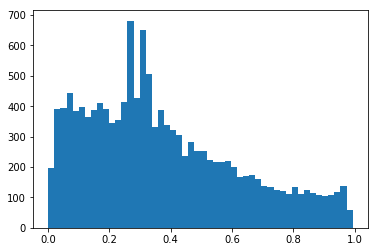


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.91      0.79      0.84     11130
           1       0.36      0.60      0.45      2210

    accuracy                           0.76     13340
   macro avg       0.63      0.70      0.65     13340
weighted avg       0.82      0.76      0.78     13340

CONFUSION MATRIX:


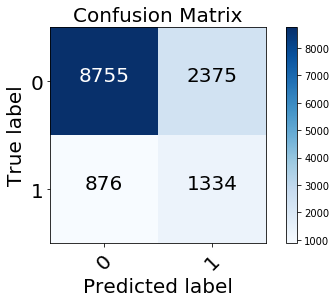

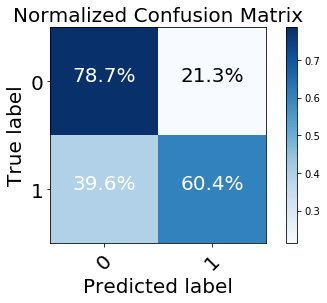

ROC CURVE:


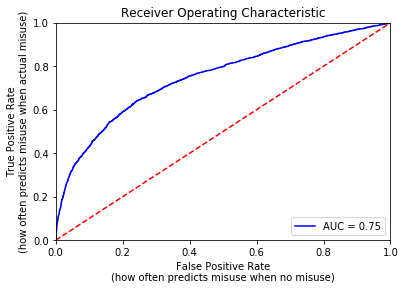

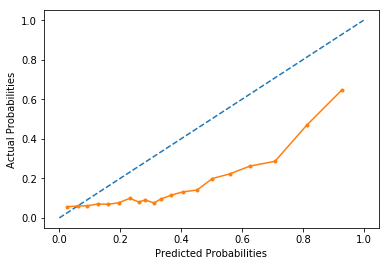

In [27]:
#Generate NN Predictions
predsNN = modelNN.predict(valX)
predProbsNN = modelNN.predict_proba(valX)[:, 1]

np.save(file=dataDir+'modelNNPredProbs.npy', arr=predProbsNN)

#Summarize
resultsSummary(predsNN, predProbsNN, valY)

# 5. Calibration

This section seeks to calibrate the model. That is, it makes the acutal probabilities from the model align with the actual probabilities.

Note, we calibrate on the validation data (valX, valY), and then evaluate with `resultsSummary` on the test data (testY)

In [28]:
#Now we'll calibrate the model
runCalibration = True

## 5.1 Calibrate Logistic Regression Model

In [29]:
if runCalibration:
    calibratorLR = CalibratedClassifierCV(modelLR, cv='prefit', method='isotonic')
    calibratorLR.fit(valX, valY)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PREDICTION COUNTS:
 [[   0 7566]
 [   1  438]]

ACCURACY SCORES:
Model Accuracy: 85.29%
Model ROC AUC:  76.98%
Brier Score Loss:  0.113
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count        8004.000000
mean            0.166288
std             0.165306
min             0.000000
25%             0.077691
50%             0.083691
75%             0.226190
max             1.000000

DISTRIBUTION OF PREDICTED PROBABILITIES:


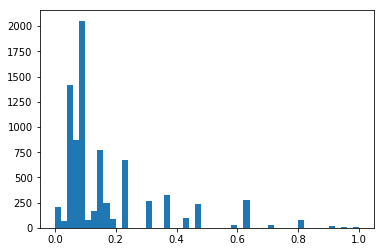


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      6693
           1       0.65      0.22      0.33      1311

    accuracy                           0.85      8004
   macro avg       0.76      0.60      0.62      8004
weighted avg       0.83      0.85      0.82      8004

CONFUSION MATRIX:


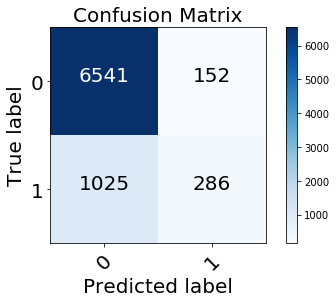

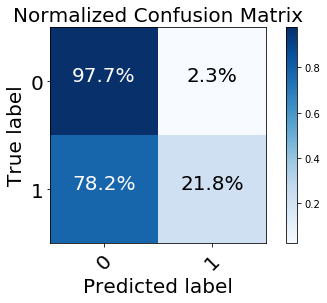

ROC CURVE:


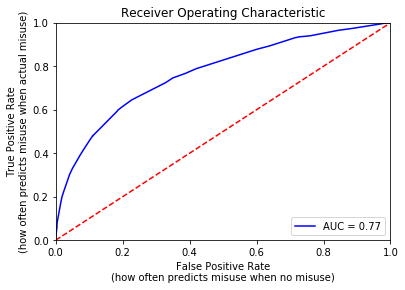

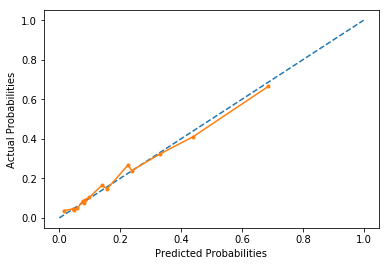

In [30]:
#Now recalculate predictions and print results
if runCalibration:
    predsLRCal = calibratorLR.predict(testX)
    predProbsLRCal = calibratorLR.predict_proba(testX)[:,1]
    resultsSummary(predsLRCal, predProbsLRCal, testY)
    
    np.save(file=dataDir+'modelLRCalPredProbs.npy', arr=predProbsLRCal)

## 5.2 Calibrate XGBoost Model

In [31]:
if runCalibration:
    calibratorXGB = CalibratedClassifierCV(modelXGB, method='sigmoid', cv='prefit')
    #cv='prefit' fails. Resorting the data didn't work.
    #Also, INCREASING TO cv=10 (FROM 3) GAVE A HUGE IMPROVEMENT.
    
    calibratorXGB.fit(valX, valY)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PREDICTION COUNTS:
 [[   0 7516]
 [   1  488]]

ACCURACY SCORES:
Model Accuracy: 85.34%
Model ROC AUC:  75.22%
Brier Score Loss:  0.115
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count        8004.000000
mean            0.165506
std             0.158047
min             0.055069
25%             0.077735
50%             0.104482
75%             0.174819
max             0.912150

DISTRIBUTION OF PREDICTED PROBABILITIES:


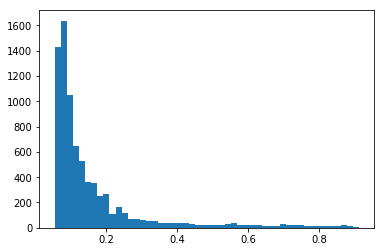


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6693
           1       0.64      0.24      0.35      1311

    accuracy                           0.85      8004
   macro avg       0.75      0.61      0.63      8004
weighted avg       0.83      0.85      0.82      8004

CONFUSION MATRIX:


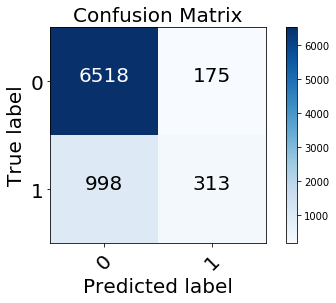

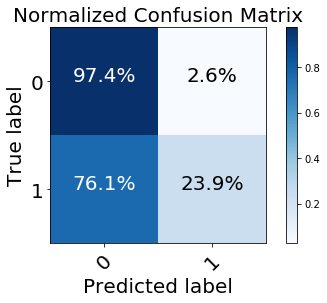

ROC CURVE:


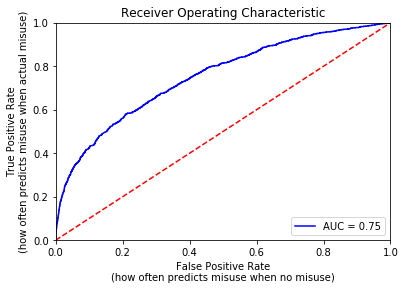

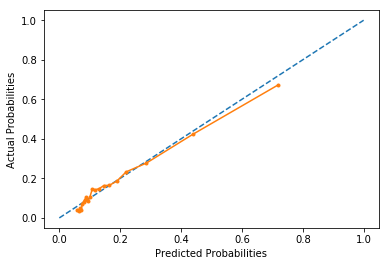

In [32]:
#Now recalculate predictions and print results
if runCalibration:
    predsXGBCal = calibratorXGB.predict(testX)
    predProbsXGBCal = calibratorXGB.predict_proba(testX)[:,1]
    resultsSummary(predsXGBCal, predProbsXGBCal, testY)
    
    np.save(file=dataDir+'modelXGBCalPredProbs.npy', arr=predProbsXGBCal)

## 5.3 Calibrate Neural Network Model

In [33]:
if runCalibration:
    calibratorNN = CalibratedClassifierCV(modelNN, method='isotonic', cv='prefit')    
    calibratorNN.fit(valX, valY)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PREDICTION COUNTS:
 [[   0 7494]
 [   1  510]]

ACCURACY SCORES:
Model Accuracy: 85.00%
Model ROC AUC:  74.71%
Brier Score Loss:  0.115
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count        8004.000000
mean            0.165285
std             0.152060
min             0.000000
25%             0.079038
50%             0.085950
75%             0.191855
max             1.000000

DISTRIBUTION OF PREDICTED PROBABILITIES:


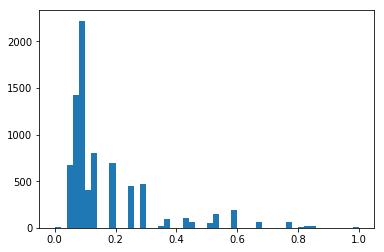


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6693
           1       0.61      0.24      0.34      1311

    accuracy                           0.85      8004
   macro avg       0.74      0.60      0.63      8004
weighted avg       0.82      0.85      0.82      8004

CONFUSION MATRIX:


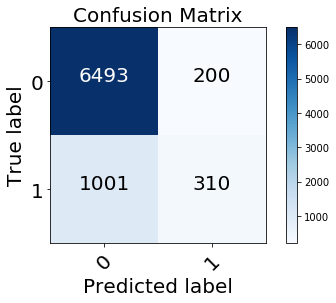

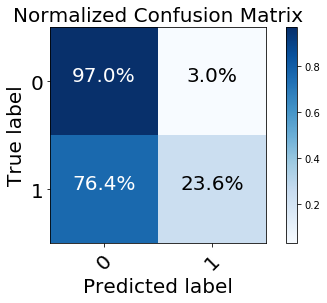

ROC CURVE:


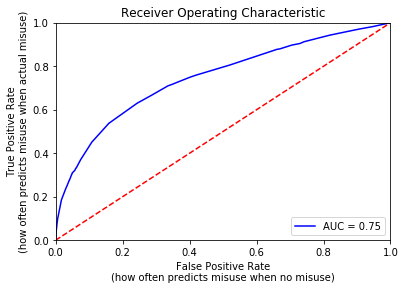

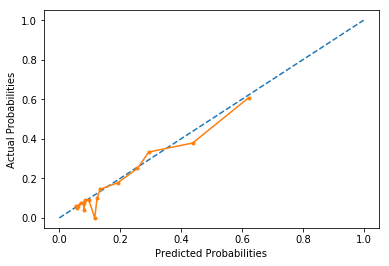

In [34]:
#Now recalculate predictions and print results
if runCalibration:
    predsNNCal = calibratorNN.predict(testX)
    predProbsNNCal = calibratorNN.predict_proba(testX)[:,1]
    resultsSummary(predsNNCal, predProbsNNCal, testY)
    
    np.save(file=dataDir+'modelNNCalPredProbs.npy', arr=predProbsNNCal)

# 6. Side By Side Model Comparisons

Here we'll look to compare results across all our models.

## 6.1 Side By Side Calibration Curves

Note these won't necessarily match the calibration curves ploted above because the ones in this section are calcualted on the test data, not the validation data. This strategy is correct because the calibrations themselves are generated from the validation data.

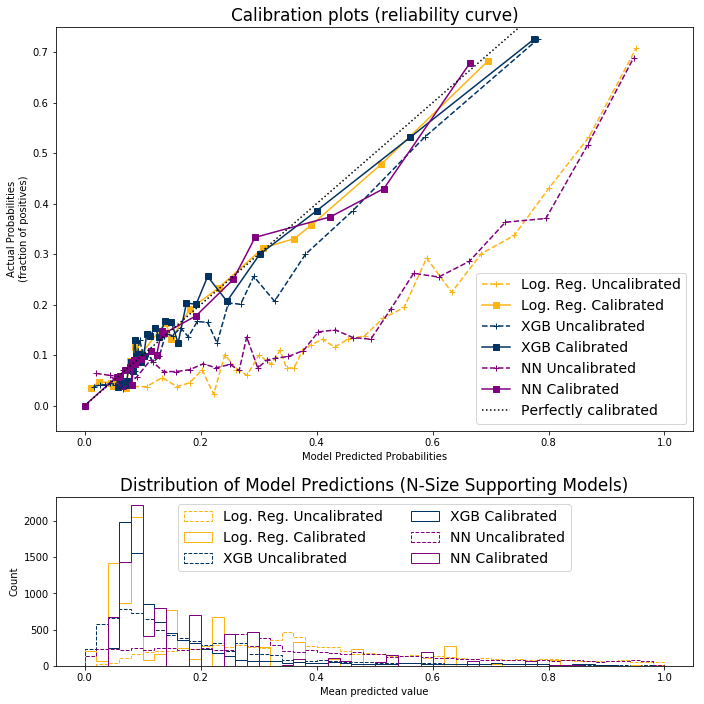

RESULTS TABLE, SORTED BY BRIER LOSS SCORE:


,Model,Brier Loss,Log Loss,ROC AUC,Precision,Recall,F1,Accuracy
0,Log. Reg. Calibrated,0.112547,0.375824,0.769777,0.652968,0.218154,0.327044,0.852949
0,XGB Calibrated,0.114786,0.379967,0.752182,0.641393,0.238749,0.347971,0.853448
0,NN Calibrated,0.115136,0.384512,0.747056,0.607843,0.236461,0.340472,0.849950
0,XGB Uncalibrated,0.116141,0.383189,0.752182,0.615658,0.263921,0.369461,0.852449
0,NN Uncalibrated,0.175088,0.534603,0.748583,0.357852,0.604882,0.449674,0.757496
0,Log. Reg. Uncalibrated,0.184656,0.558538,0.770166,0.355677,0.647597,0.459167,0.750125


In [35]:
#Initiate evaluation summary dataframe
dfEval = pd.DataFrame({'Model':[], 'Brier Loss':[], 'Log Loss':[], 'ROC AUC':[],
                       'Precision':[], 'Recall':[], 'F1':[], 'Accuracy':[]})

#Set up plots
fig = plt.figure(1, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
plt.rcParams.update({'font.size': 14})  #Set global font size

#Iterate through each model: print it scores and plot its calibration curve
for clf, name, lineColor, lineStyle in \
    [(modelLR, 'Log. Reg. Uncalibrated', '#FDB515', '+--'),
     (calibratorLR,'Log. Reg. Calibrated', '#FDB515', 's-'),
     (modelXGB, 'XGB Uncalibrated', '#003262', '+--'),     
     (calibratorXGB,'XGB Calibrated', '#003262', 's-'),
     (modelNN, 'NN Uncalibrated', 'purple', '+--'),     
     (calibratorNN,'NN Calibrated', 'purple', 's-'),
    ]:

    #Generate predictions
    preds = clf.predict(testX)
    predProbs = clf.predict_proba(testX)[:, 1]
    
    #Generate calibration curve data (strategy options are 'uniform' and 'quantile')
    prob_true, prob_pred = calibration_curve(y_true=testY, y_prob=predProbs, 
                                             n_bins=30, strategy='quantile', normalize=False)

    #Plot calibration curve
    ax1.plot(prob_pred, prob_true, lineStyle, color=lineColor, label=name)
    
    #Plot histogram of probabilities (support)
    ax2.hist(predProbs, range=(0, 1), bins=50, label=name, color=lineColor, 
             linestyle=lineStyle[1:], histtype="step", lw=1)

    #Populate evaulation dataframe    
    dictNewRow = {'Model':[name],
                  'Brier Loss':[brier_score_loss(y_true=testY, y_prob=predProbs)], 
                  'Log Loss':[log_loss(y_true=testY, y_pred=predProbs)], 
                  'ROC AUC':[roc_auc_score(y_true=testY, y_score=predProbs)], 
                  'Precision':[precision_score(y_true=testY, y_pred=preds)], 
                  'Recall':[recall_score(y_true=testY, y_pred=preds)], 
                  'F1':[f1_score(y_true=testY, y_pred=preds)], 
                  'Accuracy':[accuracy_score(y_true=testY, y_pred=preds)]
                 }
    dfEval = pd.concat([dfEval, pd.DataFrame(dictNewRow)])


#Stuff universal to all plots
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax1.set_xlabel("Model Predicted Probabilities")
ax1.set_ylabel("Actual Probabilities\n(fraction of positives)")
ax1.set_ylim([-0.05, 0.75])

ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
ax2.set_title('Distribution of Model Predictions (N-Size Supporting Models)')

zoomIn=False
if zoomIn:
    ax1.set_ylim([-0.00, 0.20])
    ax1.set_xlim([-0.00, 0.20])
    ax2.set_xlim([-0.00, 0.20])

plt.tight_layout()

plt.show() #Show plot
print('RESULTS TABLE, SORTED BY BRIER LOSS SCORE:')
dfEval.sort_values(by=['Brier Loss']) #Show eval

# 7. Compare Calibration Curves

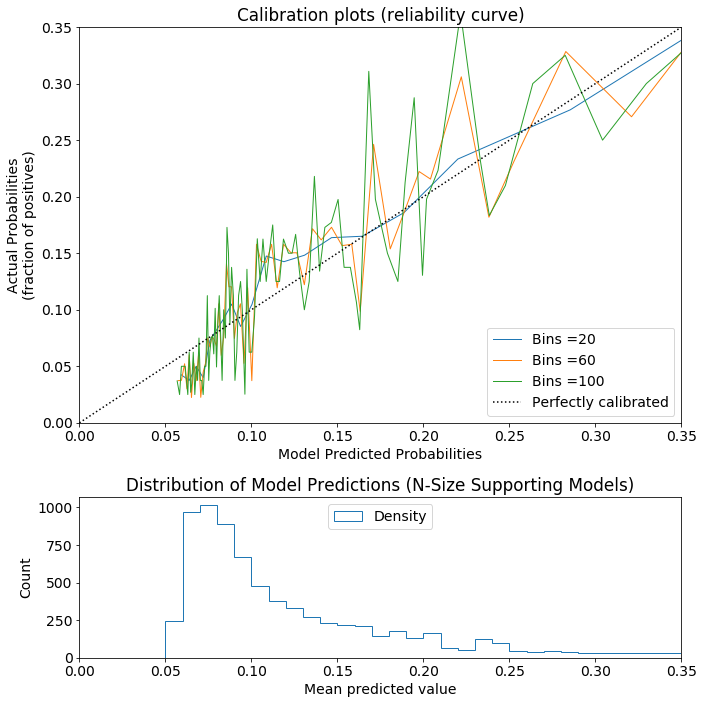

In [76]:
#Set up plots
fig = plt.figure(1, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
plt.rcParams.update({'font.size': 14})  #Set global font size

#Iterate through each model: print it scores and plot its calibration curve
for numBins in range(20,110,40):

    #Generate predictions
    preds = calibratorXGB.predict(testX)
    predProbs = calibratorXGB.predict_proba(testX)[:, 1]
    
    #Generate calibration curve data (strategy options are 'uniform' and 'quantile')
    prob_true, prob_pred = calibration_curve(y_true=testY, y_prob=predProbs, 
                                             n_bins=numBins, strategy='quantile', normalize=False)

    #Plot calibration curve
    ax1.plot(prob_pred, prob_true, label='Bins ='+str(numBins), lw=1)
    
#Plot histogram of probabilities (support)
ax2.hist(predProbs, range=(0, 1), bins=100, label='Density',
         linestyle=lineStyle[1:], histtype="step", lw=1)

#Stuff universal to all plots
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax1.set_xlabel("Model Predicted Probabilities")
ax1.set_ylabel("Actual Probabilities\n(fraction of positives)")
ax1.set_ylim([-0.05, 0.75])

ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
ax2.set_title('Distribution of Model Predictions (N-Size Supporting Models)')

zoomIn=True
if zoomIn:
    ax1.set_ylim([-0.00, 0.35])
    ax1.set_xlim([-0.00, 0.35])
    ax2.set_xlim([-0.00, 0.35])

plt.tight_layout()

plt.show() #Show plot

In [63]:
for i in range(10,110,10):
    print(i)

10
20
30
40
50
60
70
80
90
100


# 8. Save Model to Disk

Saving the model to disk at this point saves time, specifically so we don't have to re-train it every time we want to use it for predictions, feature importance, report generation, etc.

In [36]:
#Save model and any other necessary files
joblib.dump(modelLR, dataDir+'modelLR.model')
joblib.dump(modelXGB, dataDir+'modelXGB.model')
joblib.dump(modelNN, dataDir+'modelNN.model')

if runCalibration:
    joblib.dump(calibratorLR, dataDir+'calibLR.model')
    joblib.dump(calibratorXGB, dataDir+'calibXGB.model')
    joblib.dump(calibratorNN, dataDir+'calibNN.model')